In [0]:
needs_installations = False
needs_data_preparation = False
should_train_models = True

##Kaggle Integration

Upload kaggle.json file

In [0]:
if needs_installations:
  from google.colab import files
  files.upload()

In [0]:
if needs_installations:
  !ls -lha kaggle.json

In [0]:
if needs_installations:
  !pip install -q kaggle

In [0]:
if needs_installations:
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

In [0]:
if needs_installations:
  !kaggle competitions download -c quora-insincere-questions-classification -p /content/drive/My\ Drive/Colab\ Notebooks/Research/Quora/zips/

##Imports

In [8]:
# Basic Stuff
import numpy as np
import pandas as pd
from time import time, ctime
import random

# Basic Machine Learning Stuff
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# NLP Stuff
from gensim.models.keyedvectors import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')

# Deep Learning Stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader

# Visualization Stuff
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


# Drive Stuff
import urllib.request
import zipfile
import sys
import os
import pickle
import gc
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
root_path = '/content/drive/My Drive/Colab Notebooks/Research/Quora/'
zips_path = 'zips/'
data_path = 'data/'
obj_path = 'obj/'

#Data Loading

##Prepare Files

In [0]:
def save_obj(obj, name ):
    with open(root_path + obj_path + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
  if os.path.isfile(root_path + obj_path + name + '.pkl'):
    with open(root_path + obj_path + name + '.pkl', 'rb') as f:
          return pickle.load(f)

In [0]:
if needs_data_preparation:
  root_dir = os.listdir(root_path)
  zips_dir = os.listdir(root_path+zips_path)
  print(zips_dir)

In [0]:
if needs_data_preparation:
  for zip_file_name in zips_dir:
    with zipfile.ZipFile(root_path+zips_path+zip_file_name, 'r') as zip_ref:
      print('Extracting: '+root_path+zips_path+zip_file_name)
      zip_ref.extractall(root_path+data_path)

In [0]:
if needs_data_preparation:
  data_dir = os.listdir(root_path+data_path)
  print(data_dir)

In [0]:
test_data = pd.read_csv(root_path+data_path+'test.csv') 
sample_submission = pd.read_csv(root_path+data_path+'sample_submission.csv') 

###1. qid - unique question identifier
###2. question_text - Quora question text
###3. target - a question labeled "insincere" has a value of 1, otherwise 0

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Longesst Sentence Length: 412
Average Sentence Length: 14.44675688794768
Longesst Sentence: What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan(\tan({\boxed{\int_{1x^0}^{1x^2} \sum_{\varpi=1}^{\infty} \int_{2x^{-3}}^{2x^2} \sum_{\alpha=7}^{\infty} \underbrace{\sqrt[2]{1x^5}}_{\text{Gauss's Law of Theoretical Probability.}} d\tau dx}}^{1x^0})) d\mu}{\int_{2x^{-3}}^{1x^5} \cos(\int_{2x^2}^{1x^{-3}} \frac{\sqrt[2]{\overbrace{\underbrace{\frac{3x^3+3x^5}{\sqrt[3]{2x^{-3}}}}_{\text{Gauss's Law of Theoretical Probability.}} \times \overbrace{\tan(2x^0)}^{\text{Gauss's Law of Theoretical Probability.}}-\sum_{4=7}^{\infty} \boxed{3x^{-5}}}^{\text{Inverse Function.}}}}{{\boxed{\int_{2x^2}^{2x^4} 3x^1 d9} \div \sum_{6=6}^{\infty} \sqrt[3]{2x^2}+\sqrt[4]{\sin(2x^0+3x^0)}}^{2x^{-4}}+\boxed{\frac{\vec{\boxed{\sum_{\gamma=10}^{\infty} 1x^{-5}}}}{\frac{\sum_{\iota=2}^{\infty} 1x^{-5}-\frac{3x^{-1}}{1x^{-4}}}{\sin(\tan(3x^{-2}))}}}} \times \boxed{\sqrt[2]{{{{\sqrt[5]{2x^5}}^{2x^{-1}}}^{2x^{-1}} \div \sum_{

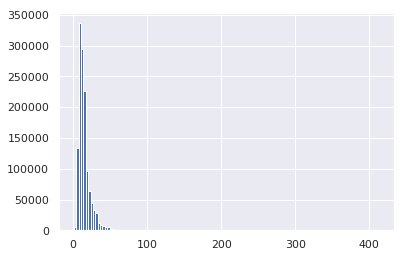

In [15]:
if needs_data_preparation:
  train_data = pd.read_csv(root_path+data_path+'train.csv') 
  train_data['question_length'] = train_data.apply(lambda x: len(word_tokenize(x['question_text'])),axis=1)
  train_data.to_csv(root_path+data_path+'train_data_with_length.csv')
else:
  train_data = pd.read_csv(root_path+data_path+'train_data_with_length.csv',index_col=0) 

m = np.max(train_data['question_length'])
max_sentence = train_data.iloc[train_data['question_length'].idxmax()]['question_text']
avg = np.mean(train_data['question_length'])
print("Longesst Sentence Length: "+str(m))
print("Average Sentence Length: "+str(avg))
print("Longesst Sentence: "+str(max_sentence))
train_data['question_length'].hist(bins=128)

In [16]:
pd.set_option('max_colwidth', 128)
train_data.head(1)

,qid,question_text,target,question_length
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,14


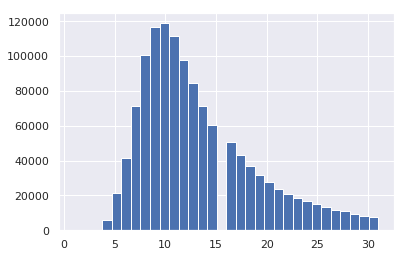

In [17]:
train_data[train_data['question_length']<32]['question_length'].hist(bins=32)

In [0]:
pos_data = train_data[train_data['target']==1]
neg_data = train_data[train_data['target']==0]

In [19]:
neg_data.head(3)

,qid,question_text,target,question_length
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,14
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,18
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,12


In [20]:
pos_data.head(3)

,qid,question_text,target,question_length
22,0000e91571b60c2fb487,Has the United States become the largest dictatorship in the world?,1,12
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents? Dark skin babies or light skin babies?,1,17
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory sentencing for criminals why don't they vote Republican?,1,17


In [21]:
print("There are total of "+str(train_data.size)+" samples")
print("There are "+str(pos_data.size)+" positive samples (insincere)")
print("There are "+str(neg_data.size)+" negative samples (sincere)")
print("Ratio is: %.3f" % (pos_data.size/neg_data.size))

There are total of 5224488 samples
There are 323240 positive samples (insincere)
There are 4901248 negative samples (sincere)
Ratio is: 0.066


In [22]:
train_data_balanced = pd.concat([resample(neg_data,replace = False,n_samples = len(pos_data)), pos_data])
print("There are total of "+str(train_data_balanced.shape)+" samples")
train_data_balanced.head(3)

There are total of (161620, 4) samples


,qid,question_text,target,question_length
321222,3ef4fc9c0ff6b72f949b,How can one find peace in this hullabaloo of the world?,0,12
167120,20a6443fa129ab48fdfb,How many student called for counselling in BHU for social science?,0,12
253878,31afe34074608380a609,What are the importance of trees in human life?,0,10


###Resample Data

In [23]:
X,y = train_data_balanced.iloc[:,:2],train_data_balanced.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
number_of_samples = 50000
updated_train_data_resampled = pd.concat([X_train, y_train],axis=1)
train_data_balanced_resampled = resample(updated_train_data_resampled,replace = False,n_samples = number_of_samples)
X_train_resampled, y_train_resampled = train_data_balanced_resampled.iloc[:,:2],train_data_balanced_resampled.iloc[:,2]
chosen_question_length = 32
word_vector_size = 300
X_train_resampled.head(1)

,qid,question_text
499569,61cdf66a268622a197e0,Is Matt Damon's IQ actually 160?


## Embeddings

###Challenges:
1. Sentences are in different lengths
2. Sequence order does matter

In [0]:
data_dir = os.listdir(root_path+data_path)
data_dir

['train.csv',
 'GoogleNews-vectors-negative300',
 'glove.840B.300d',
 'paragram_300_sl999',
 'wiki-news-300d-1M',
 'sample_submission.csv',
 'test.csv',
 'gensim_glove_vectors.txt',
 'train_data_with_length.csv',
 'paragram_glove_vectors.txt',
 'gensim_paragram_vectors.txt']

In [0]:
class QIQModel:
  def run_on_all(self,X_train,y_train,X_test,y_test):
    results = []
    results.append(self.run_on_model(X_train,y_train,X_test,y_test,self.get_glove_embeddings()))
    results.append(self.run_on_model(X_train,y_train,X_test,y_test,self.get_google_news_embeddings()))
    results.append(self.run_on_model(X_train,y_train,X_test,y_test,self.get_wiki_news_embeddings()))
    return results

  def run_on_model(self,X_train,y_train,X_test,y_test,embeddings):
    X_train,y_train,X_test,y_test = self.prepare_data(X_train,y_train,X_test,y_test,embeddings)
    result = self.run(X_train,y_train,X_test,y_test)
    print(result)
    return result

  def run(self,X_train,y_train,X_test,y_test):
    return 0.0

  def prepare_data(self,X_train,y_train,X_test,y_test,embeddings):
    chosen_question_length = 32
    word_vector_size = 300

    X_train_vectorized = self.reduce_dim_from_3_to_2(self.vectorize(X_train,chosen_question_length,word_vector_size,embeddings))
    X_test_vectorized = self.reduce_dim_from_3_to_2(self.vectorize(X_test,chosen_question_length,word_vector_size,embeddings))

    return X_train_vectorized,y_train,X_test_vectorized,y_test

  def reduce_dim_from_3_to_2(self,X):
    nsamples, nx, ny = X.shape
    return X.reshape((nsamples,nx*ny))

  def vectorize(self,X,chosen_question_length,word_vector_size,embeddings):
    X_vectorized = np.empty((X.shape[0],chosen_question_length,word_vector_size))
    for i in range(X.shape[0]):
      current_sentence = word_tokenize(X.iloc[i]['question_text'])
      for j in range(chosen_question_length):
        if j<len(current_sentence) and current_sentence[j] in embeddings:
          X_vectorized[i,j] = embeddings[current_sentence[j]]
        else:
          X_vectorized[i,j] = np.zeros((300,))
      if i % 10000 ==0:
        print(i,end ="-")
    return X_vectorized  

  def get_glove_embeddings(self):
    if needs_data_preparation:
      glove2word2vec(glove_input_file=root_path+data_path+'glove.840B.300d/glove.840B.300d.txt', word2vec_output_file=root_path+data_path+"gensim_glove_vectors.txt")    
    return KeyedVectors.load_word2vec_format(root_path+data_path+"gensim_glove_vectors.txt", binary=False)
  def get_google_news_embeddings(self):
    return KeyedVectors.load_word2vec_format(root_path+data_path+'GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin', binary=True)
  # TODO: fix this one
  def get_paragram_embeddings(self):
    if needs_data_preparation:
      glove2word2vec(glove_input_file=root_path+data_path+'paragram_300_sl999/paragram_300_sl999.txt', word2vec_output_file=root_path+data_path+"gensim_paragram_vectors.txt")
    paragram_model = KeyedVectors.load_word2vec_format(root_path+data_path+'paragram_300_sl999/paragram_300_sl999.txt', binary=False)
    return paragram_model
  def get_wiki_news_embeddings(self):
    return KeyedVectors.load_word2vec_format(root_path+data_path+'wiki-news-300d-1M/wiki-news-300d-1M.vec', binary=False)


###Sanity Check

In [0]:
# m = QIQModel()
# embed = m.get_wiki_news_embeddings()
# print(embed['Hello'].shape)
# del m
# del embed
# gc.collect()

In [22]:
X_train_resampled.shape

(50000, 2)

##Baseline Models

###Logistic Regression

In [0]:
class LRModel(QIQModel):
  def run(self,X_train,y_train,X_test,y_test):
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
    print(clf)
    return clf.score(X_test, y_test)

In [0]:
lr = LRModel()
results = lr.run_on_all(X_train_resampled, y_train_resampled, X_test, y_test)
results

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0-10000-20000-30000-40000-0-10000-20000-30000-

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.8457492884543992


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0-10000-20000-30000-40000-0-10000-20000-30000-

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.8410778369013736


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0-10000-20000-30000-40000-0-10000-20000-30000-

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.8527409974013117


[0.8457492884543992, 0.8410778369013736, 0.8527409974013117]

###Naive Baise

In [0]:
class GNBModel(QIQModel):
  def run(self,X_train,y_train,X_test,y_test):
    gnb = GaussianNB().fit(X_train, y_train)
    print(gnb)
    return gnb.score(X_test, y_test)

In [24]:
gnb = GNBModel()
results = gnb.run_on_all(X_train_resampled, y_train_resampled, X_test, y_test)
results

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0-10000-20000-30000-40000-0-10000-20000-30000-GaussianNB(priors=None, var_smoothing=1e-09)
0.6191993565152828


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0-10000-20000-30000-40000-0-10000-20000-30000-GaussianNB(priors=None, var_smoothing=1e-09)
0.6204987006558594


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0-10000-20000-30000-40000-0-10000-20000-30000-GaussianNB(priors=None, var_smoothing=1e-09)
0.6195396609330528


[0.6191993565152828, 0.6204987006558594, 0.6195396609330528]

###XGBoost

In [0]:
class XGBModel(QIQModel):
  def run(self,X_train,y_train,X_test,y_test):
    gbm = XGBClassifier()
    print(gbm)
    gbm.fit(X_train, y_train)
    return gbm.score(X_test, y_test)

In [0]:
xgb = XGBModel()
results = xgb.run_on_all(X_train_resampled, y_train_resampled, X_test, y_test)
results

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


0-10000-20000-30000-40000-0-10000-20000-30000-

In [0]:
def predict(clf,sentnce):
  X_vectorized = np.empty((1,chosen_question_length,word_vector_size))
  current_sentence = word_tokenize(sentnce)
  for j in range(chosen_question_length):
    if j<len(current_sentence) and current_sentence[j] in glove_model:
      X_vectorized[0,j] = glove_model[current_sentence[j]]
    else:
      X_vectorized[0,j] = np.zeros((300,))
  return clf.predict(X_vectorized.reshape(1,chosen_question_length*word_vector_size))

In [0]:
lets_have_fun = ["What is wrong with fat ass?","What is love?","What is wrong with fat milk?","Do Arabs eat humus?","Do aliens exist?"]

for s in lets_have_fun:
  result = predict(clf,s)
  print(s+'\t is '+ ('insincere' if predict(clf,s)[0] else 'sincere'))

What is wrong with fat ass?	 is insincere
What is love?	 is sincere
What is wrong with fat milk?	 is insincere
Do Arabs eat humus?	 is insincere
Do aliens exist?	 is sincere


##Baseline Results

In [36]:
results = np.array([[0.8457492884543992, 0.8410778369013736, 0.8527409974013117],[0.6191993565152828, 0.6204987006558594, 0.6195396609330528]]).T
summery_df = pd.DataFrame(results, columns=['Logistic Regression', 'Gaussian Naive Bayes'])
summery_df.index.name = 'Embeddings'
summery_df.index = ['Glove','Google News','Wiki News']
summery_df.head()

,Logistic Regression,Gaussian Naive Bayes
Glove,0.845749,0.619199
Google News,0.841078,0.620499
Wiki News,0.852741,0.619540


In [0]:
class QuoraDataset(Dataset):
  def __init__(self,X_train,y_train):
    print("Init QuoraDataset at: "+str(ctime()))
    self.X_train = X_train
    self.y_train = y_train
    self.embeddings = self.get_wiki_news_embeddings()
    print("Finish init QuoraDataset at: "+str(ctime()))

  def get_glove_embeddings(self):
    return KeyedVectors.load_word2vec_format(root_path+data_path+"gensim_glove_vectors.txt", binary=False)

  def get_wiki_news_embeddings(self):
    return KeyedVectors.load_word2vec_format(root_path+data_path+'wiki-news-300d-1M/wiki-news-300d-1M.vec', binary=False)
   
  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    X = self.prepare_data(self.X_train.iloc[idx:idx+1,:])
    return (X,self.y_train.iloc[idx])

  def prepare_data(self,X_train):
    chosen_question_length = 32
    word_vector_size = 300

    X_train_vectorized = self.vectorize(X_train,chosen_question_length,word_vector_size)

    return X_train_vectorized

  def vectorize(self,X,chosen_question_length,word_vector_size):
    X_vectorized = np.empty((X.shape[0],chosen_question_length,word_vector_size))
    for i in range(X.shape[0]):
      current_sentence = word_tokenize(X.iloc[i]['question_text'])
      for j in range(chosen_question_length):
        if j<len(current_sentence) and current_sentence[j] in self.embeddings:
          X_vectorized[i,j] = self.embeddings[current_sentence[j]]
        else:
          X_vectorized[i,j] = np.zeros((300,))
    return X_vectorized  

In [27]:
X_train.iloc[0:1,:]

,qid,question_text
264449,33bf9a08bc466a8439f2,Why do Christians in India hate Brahmins so much?


In [28]:
quora_train_set = QuoraDataset(X_train,y_train)
quora_dataloader = DataLoader(quora_train_set, batch_size=50, shuffle=True)

Init QuoraDataset at: Thu Sep 19 12:02:13 2019


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Finish init QuoraDataset at: Thu Sep 19 12:07:00 2019


In [29]:
quora_train_set

In [0]:
class YKCNN(nn.Module):
    def __init__(self, channels_number=1):
      super(YKCNN, self).__init__()

      self.conv1 = nn.Conv2d(in_channels=channels_number, out_channels=100, kernel_size=(5,300),stride=(1,1), padding=(2,0))
      # self.conv1 = nn.Conv2d(in_channels=channels_number, out_channels=100, kernel_size=(7,300),stride=(1,1), padding=(3,0))
      self.fc1 = nn.Linear(in_features = 600, out_features = 2)
      # self.batch_norm = nn.BatchNorm1d(num_features=120)

    def forward(self, x):
        x = x.float()
        x = F.max_pool2d(torch.tanh(self.conv1(x)), (5,300))
        # x = F.max_pool2d(F.tanh(self.conv2(x)), (5,300))
        x = x.view(-1, self.num_flat_features(x))
        # print("I'm inlove with the shape of x: "+str(x.shape)+" after flattening")
        x = F.dropout(x)
        x = self.fc1(x)
        # print("I'm inlove with the shape of x: "+str(x.shape)+" after fc1")
        # x = self.batch_norm(x)
        x = F.log_softmax(x,dim=0)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [31]:
torch.cuda.is_available()

True

In [32]:
net = YKCNN().cuda()     # -- For GPU
print(net)

YKCNN(
  (conv1): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1), padding=(2, 0))
  (fc1): Linear(in_features=600, out_features=2, bias=True)
)


In [0]:
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()

In [0]:
# training loop
def train(net, trainloader, epochs=30):
  loss_array = []
  for epoch in range(epochs):  
    torch.save(net.state_dict(), root_path+data_path+'model')
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        # print("Data Loading starts at: "+str(ctime()))
        # print(data[0].shape)
        inputs, labels = data
        # print("Finished fetching "+str(len(inputs))+" items at: "+str(ctime()))

        inputs = inputs.cuda() # -- For GPU
        labels = labels.cuda() # -- For GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        # print(inputs.shape)
        # print("Forward starts at: "+str(ctime()))
        outputs = net(inputs)

        # print("Loss starts at: "+str(ctime()))
        loss = criterion(outputs, labels)
        # print("Backward starts at: "+str(ctime()))
        loss.backward()
        # print("Optimizer starts at: "+str(ctime()))
        optimizer.step()
        # print("Optimizer ends at: "+str(ctime()))

        # print statistics
        # print(loss.item())
        running_loss += loss.item()
        if (i % 200 == 0) and (i > 0):    
            print('%s: [%d, %5d] loss: %.3f' %
                  (ctime().split()[3], epoch, i, running_loss / 200))

            loss_array.append(running_loss / 200)
            running_loss = 0.0
        # print("Step ends at: "+str(ctime()+"\n"))
             
  print('Finished Training')
  return loss_array

In [37]:
original_loss_array = train(net, quora_dataloader)

12:11:29: [0,   200] loss: 0.310
12:11:38: [0,   400] loss: 0.310
12:11:47: [0,   600] loss: 0.305
12:11:56: [0,   800] loss: 0.318
12:12:05: [0,  1000] loss: 0.313
12:12:14: [0,  1200] loss: 0.297
12:12:23: [0,  1400] loss: 0.302
12:12:33: [0,  1600] loss: 0.296
12:12:42: [0,  1800] loss: 0.299
12:12:51: [0,  2000] loss: 0.305
12:13:00: [0,  2200] loss: 0.294
12:13:09: [0,  2400] loss: 0.300
12:13:27: [1,   200] loss: 0.270
12:13:36: [1,   400] loss: 0.276
12:13:45: [1,   600] loss: 0.286
12:13:54: [1,   800] loss: 0.287
12:14:04: [1,  1000] loss: 0.277
12:14:13: [1,  1200] loss: 0.291
12:14:23: [1,  1400] loss: 0.279
12:14:32: [1,  1600] loss: 0.298
12:14:41: [1,  1800] loss: 0.278
12:14:50: [1,  2000] loss: 0.273
12:14:59: [1,  2200] loss: 0.282
12:15:08: [1,  2400] loss: 0.284
12:15:26: [2,   200] loss: 0.258
12:15:35: [2,   400] loss: 0.264
12:15:44: [2,   600] loss: 0.281
12:15:53: [2,   800] loss: 0.262
12:16:03: [2,  1000] loss: 0.269
12:16:12: [2,  1200] loss: 0.268
12:16:21: 

In [0]:
# save_obj(net, 'net_conv_5')
net = load_obj('net_conv_5')
# save_obj(net, 'net_conv_7')

In [28]:
net

YKCNN(
  (conv1): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1), padding=(2, 0))
  (fc1): Linear(in_features=600, out_features=2, bias=True)
)

In [1]:
del quora_train_set
del quora_dataloader
gc.collect()

NameError: ignored

(360, 1)
(360, 1)


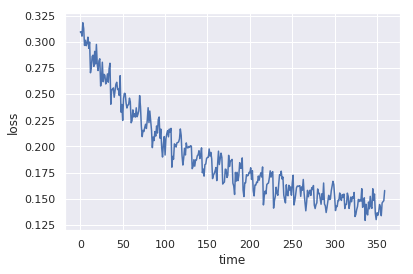

In [39]:
a = np.array(original_loss_array).reshape((len(original_loss_array),1))
print(a.shape)
b = np.array([float(i) for i in range(len(original_loss_array))]).reshape((len(original_loss_array),1))
print(b.shape)

data = pd.DataFrame(np.concatenate((a,b),axis=1), columns = ["loss","time"])
# data.head()
ax = sns.lineplot(x="time", y="loss", data=data)

In [29]:
quora_test_set = QuoraDataset(X_test,y_test)
quora_test_dataloader = DataLoader(quora_test_set, batch_size=50, shuffle=True)

Init QuoraDataset at: Thu Sep 19 13:23:51 2019


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Finish init QuoraDataset at: Thu Sep 19 13:28:44 2019


In [0]:
def evaluate(quora_test_dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    for data in quora_test_dataloader:
      # print(data[0].shape)
      inputs, labels =  data
      inputs, labels = inputs.cuda(), labels.cuda()
      
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test sentences: %d %%' % (
      100 * correct / total))

In [31]:
evaluate(quora_test_dataloader)

Accuracy of the network on the test sentences: 86 %


In [32]:
del quora_test_set
del quora_test_dataloader
gc.collect()

0

In [0]:
class QuoraNonStaticDataset(Dataset):
  
  def __init__(self,X_train,y_train):
    print("Init QuoraNonStaticDataset at: "+str(ctime()))
    self.X_train = X_train
    self.y_train = y_train
    self.embeddings = self.get_wiki_news_embeddings()
    print("Finish init QuoraNonStaticDataset at: "+str(ctime()))

  def get_glove_embeddings(self):
    return KeyedVectors.load_word2vec_format(root_path+data_path+"gensim_glove_vectors.txt", binary=False)

  def get_wiki_news_embeddings(self):
    return KeyedVectors.load_word2vec_format(root_path+data_path+'wiki-news-300d-1M/wiki-news-300d-1M.vec', binary=False)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self, idx):
    X = self.prepare_data(self.X_train.iloc[idx:idx+1,:])
    return (X,self.y_train.iloc[idx])

  def prepare_data(self,X_train):
    chosen_question_length = 32

    X_train_vectorized = self.vectorize(X_train,chosen_question_length)

    return X_train_vectorized

  def vectorize(self,X,chosen_question_length):
    X_vectorized = np.empty((X.shape[0],chosen_question_length),dtype=np.long)
    for i in range(X.shape[0]):
      current_sentence = word_tokenize(X.iloc[i]['question_text'])
      for j in range(chosen_question_length):
        if j<len(current_sentence) and current_sentence[j] in self.embeddings:
          X_vectorized[i,j] = self.embeddings.vocab[current_sentence[j]].index
        else:
          X_vectorized[i,j] = 0
    return X_vectorized

In [25]:
non_static_dataset = QuoraNonStaticDataset(X_train,y_train)

Init QuoraNonStaticDataset at: Thu Sep 19 15:40:55 2019


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Finish init QuoraNonStaticDataset at: Thu Sep 19 15:45:49 2019


In [0]:
train_loader = DataLoader(non_static_dataset, shuffle=True, batch_size=50)

In [0]:
class QIQRNN(nn.Module):
  def __init__(self, output_size, hidden_dim, n_layers, drop_prob=0.5):
    super(QIQRNN, self).__init__()
    print("Init QIQRNN at: "+str(ctime()))

    self.n_layers = n_layers
    self.hidden_dim = hidden_dim

    # embedding and LSTM layers
    self.embedding = nn.Embedding.from_pretrained(self.get_wiki_news_embeddings(), freeze=False)
    self.lstm = nn.LSTM(300, hidden_dim, n_layers,dropout=drop_prob, batch_first=True)

    # dropout layer
    self.dropout = nn.Dropout(0.3)

    # linear and sigmoid layers
    self.fc = nn.Linear(hidden_dim, 2)
    self.sig = nn.Sigmoid()
    print("Finished init QIQRNN at: "+str(ctime()))

  def forward(self, x, hidden):
    batch_size = x.size(0)

    # embeddings and lstm_out
    embeds = self.embedding(x)
    lstm_out, hidden = self.lstm(embeds, hidden)

    # stack up lstm outputs
    lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

    # dropout and fully-connected layer
    out = self.dropout(lstm_out)
    out = self.fc(out)

    # sigmoid function
    sig_out = self.sig(out)

    # reshape to be batch_size first
    sig_out = sig_out.view(batch_size, -1)
    sig_out = sig_out[:, -1] # get last batch of labels

    # return last sigmoid output and hidden state
    return sig_out, hidden

  def init_hidden(self, batch_size):
    # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    # initialized to zero, for hidden state and cell state of LSTM
    weight = next(self.parameters()).data

    hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
    return hidden

  def get_glove_embeddings(self):
    embd = KeyedVectors.load_word2vec_format(root_path+data_path+"gensim_glove_vectors.txt", binary=False)
    embd = torch.from_numpy(embd.vectors)
    return embd
  
  def get_wiki_news_embeddings(self):
    embd = KeyedVectors.load_word2vec_format(root_path+data_path+'wiki-news-300d-1M/wiki-news-300d-1M.vec', binary=False)
    embd = torch.from_numpy(embd.vectors)
    return embd
    

In [28]:
output_size = 1
hidden_dim = 256
n_layers = 2
net = QIQRNN(output_size, hidden_dim, n_layers).cuda()     # -- For GPU
print(net)

Init QIQRNN at: Thu Sep 19 15:46:04 2019


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Finished init QIQRNN at: Thu Sep 19 15:50:54 2019
QIQRNN(
  (embedding): Embedding(999994, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3)
  (fc): Linear(in_features=256, out_features=2, bias=True)
  (sig): Sigmoid()
)


In [29]:
torch.cuda.is_available()

True

In [0]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters())

In [0]:
# training loop
def train(net, trainloader, epochs=5):
  counter = 0
  batch_size = 50
  print_every = 200
  clip=5 # gradient clipping
  loss_array = []
  loss_time_array = []

  # net.train()

  for epoch in range(epochs):  
    # torch.save(net.state_dict(), root_path+data_path+'rnn_model')
    h = net.init_hidden(batch_size)

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        # print("Data Loading starts at: "+str(ctime()))
        # print(data[0].shape)
        counter += 1
        inputs, labels = data

        # print("Finished fetching "+str(len(inputs))+" items at: "+str(ctime()))

        inputs = inputs.squeeze()
        labels = labels.cuda() # -- For GPU

        # forward + backward + optimize

        if (inputs.shape[0]<batch_size):
          continue

        # print(inputs.shape)
        # print(inputs[0])
        inputs_long = torch.LongTensor(inputs).cuda() # -- For GPU

        # print("Forward starts at: "+str(ctime()))
        h = tuple([each.data for each in h])

        # zero the parameter gradients
        net.zero_grad()

        output, h = net(inputs_long, h)

        # print("Loss starts at: "+str(ctime()))
        loss = criterion(output.squeeze(), labels.float())

        # print("Backward starts at: "+str(ctime()))
        loss.backward()

        # print("Optimizer starts at: "+str(ctime()))
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()
        # print("Optimizer ends at: "+str(ctime()))

        running_loss += loss.item()
        if (i % 200 == 0) and (i > 0):    
            print('%s: [%d, %5d] loss: %.3f' %
                  (ctime().split()[3], epoch, i, running_loss / 200))

            loss_array.append(running_loss / 200)
            loss_time_array.append(ctime().split()[3])
            running_loss = 0.0
        # print("Step ends at: "+str(ctime()+"\n"))
             
  print('Finished Training')
  return loss_array, loss_time_array

In [34]:
rnn_loss_array, rnn_loss_time_array = train(net, train_loader)
save_obj(net, 'net_lstm_rnn')
save_obj(rnn_loss_array, 'rnn_loss_array')
save_obj(rnn_loss_array, 'rnn_loss_time_array')
# net = load_obj('net_lstm_rnn')


16:00:56: [0,   200] loss: 0.269
16:01:46: [0,   400] loss: 0.275
16:02:37: [0,   600] loss: 0.270
16:03:28: [0,   800] loss: 0.272
16:04:19: [0,  1000] loss: 0.274
16:05:10: [0,  1200] loss: 0.262
16:06:01: [0,  1400] loss: 0.261
16:06:52: [0,  1600] loss: 0.268
16:07:42: [0,  1800] loss: 0.269
16:08:33: [0,  2000] loss: 0.284
16:09:24: [0,  2200] loss: 0.269
16:10:15: [0,  2400] loss: 0.273
16:11:53: [1,   200] loss: 0.202
16:12:44: [1,   400] loss: 0.202
16:13:35: [1,   600] loss: 0.213
16:14:26: [1,   800] loss: 0.206
16:15:17: [1,  1000] loss: 0.200
16:16:08: [1,  1200] loss: 0.208
16:16:59: [1,  1400] loss: 0.206
16:17:50: [1,  1600] loss: 0.214
16:18:41: [1,  1800] loss: 0.197
16:19:32: [1,  2000] loss: 0.224
16:20:22: [1,  2200] loss: 0.217
16:21:13: [1,  2400] loss: 0.212
16:22:52: [2,   200] loss: 0.163
16:23:43: [2,   400] loss: 0.159
16:24:33: [2,   600] loss: 0.155
16:25:24: [2,   800] loss: 0.152
16:26:15: [2,  1000] loss: 0.162
16:27:06: [2,  1200] loss: 0.166
16:27:57: 

(60, 1)


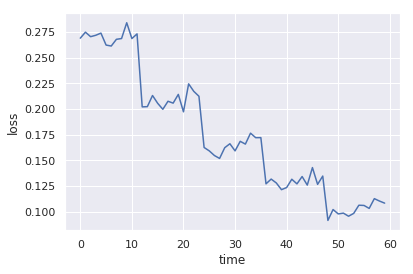

In [37]:
a = np.array(rnn_loss_array).reshape((len(rnn_loss_array),1))
b = np.array([float(i) for i in range(len(rnn_loss_array))]).reshape((len(rnn_loss_array),1))
print(b.shape)

data = pd.DataFrame(np.concatenate((a,b),axis=1), columns = ["loss","time"])
# data.head()
ax = sns.lineplot(x="time", y="loss", data=data)

In [38]:
del non_static_dataset
del train_loader
gc.collect()

1000626

In [39]:
non_static_test_set = QuoraNonStaticDataset(X_test,y_test)
test_loader = DataLoader(non_static_test_set, shuffle=True, batch_size=50)

Init QuoraNonStaticDataset at: Thu Sep 19 17:03:45 2019


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Finish init QuoraNonStaticDataset at: Thu Sep 19 17:08:39 2019


In [0]:
def evaluate(quora_test_dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    h = net.init_hidden(50)
    for data in quora_test_dataloader:
      # print(data[0].shape)
      inputs, labels =  data
      inputs, labels =  inputs.squeeze(), labels.cuda()
      if (inputs.shape[0]<50):
        continue   
      inputs_long = torch.LongTensor(inputs).cuda() # -- For GPU

      outputs, h = net(inputs_long, h)
      # print(outputs)
      predicted = torch.round(outputs.squeeze()).long()
      # _, predicted = torch.max(outputs.data, 1)
      # print(predicted)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test sentences: %d %%' % (
      100 * correct / total))

In [41]:
evaluate(test_loader)

Accuracy of the network on the test sentences: 87 %
